In [1]:
import torch
import time
import torchvision
import numpy as np
from torch import nn,optim
import matplotlib.pyplot as plt
%matplotlib inline

- 手写实现

In [2]:
def get_ch7_data():
    data=np.genfromtxt(r'F:\study\ml\DataSet\airfoil_self_noise\airfoil_self_noise.dat',
                      delimiter='\t')
    data=(data-data.mean(axis=0)) / data.std(axis=0)
    features=torch.tensor(data[:1500,:-1],dtype=torch.float32)
    labels=torch.tensor(data[:1500,-1],dtype=torch.float32)
    return features,labels

In [3]:
features,labels=get_ch7_data()
features.shape

torch.Size([1500, 5])

In [12]:
def linreg(x,w,b):
    return torch.mm(x,w)+b

def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2

def momentum_init():
    v_w=torch.zeros((features.shape[1],1),dtype=torch.float32)
    v_b=torch.zeros((1),dtype=torch.float32)
    return (v_w,v_b)

def momentum_sgd(params,status,hyperparams):
    for p,v in zip(params,status):
        v.data=v.data*hyperparams['gamma']+p.grad.data*hyperparams['lr']
        p.data -= v.data
        
# def sgd_momentum(params,states,hyperparams):
#     print('params')
#     for p,v in zip(params,states):
#         v.data=hyperparams['gamma']*v.data +hyperparams['lr']*p.grad.data
#         p.data -=v.data        
        
    

In [31]:
def train_ch7(optimizer_fn,states,hyperparams,features,labels,
             batch_size=10,num_epochs=2):
    net,loss=linreg,squared_loss
    w=torch.nn.Parameter(torch.tensor(
    np.random.normal(0,0.01,size=(features.shape[1],1)),dtype=torch.float32),
                         requires_grad=True)
    b=torch.nn.Parameter(torch.tensor(
    np.zeros(1),dtype=torch.float32),
                         requires_grad=True)
    
    data_iter=torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,
        shuffle=True)

    def eval_loss():
        return loss(net(features,w,b),labels).mean().item()/2
    
    ls=[eval_loss()]
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X,w,b),y).mean() /2
#             print('l: ',l)
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            optimizer_fn([w,b],states,hyperparams)
            if (batch_i+1) * batch_size % 100 == 0 :
                ls.append(eval_loss())
    print('loss %f , %f sec per epoch' % (ls[-1],time.time()-start))
#     print(ls)
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')
            

loss 0.243278 , 0.054003 sec per epoch


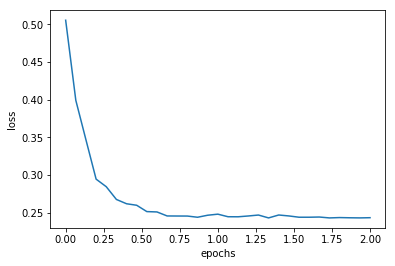

In [32]:
train_ch7(momentum_sgd,momentum_init(),{'gamma':0.5,'lr':0.02},features,labels)

loss 0.261555 , 0.053003 sec per epoch


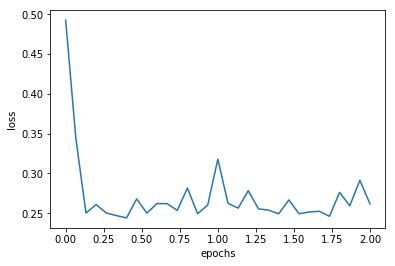

In [33]:
train_ch7(momentum_sgd,momentum_init(),{'gamma':0.9,'lr':0.02},features,labels)

In [35]:
# train_ch7(momentum_sgd,momentum_init(),{'gamma':0.9,'lr':0.004},features,labels)

- pytorch 的nn 实现

In [71]:
def train_pytorch_ch7(optimizer_fn,hyperparams,features,labels,batch_size=10,
                     num_epochs=2):
    net=torch.nn.Sequential(nn.Linear(features.shape[1],1))
    loss=nn.MSELoss()
    
    optimizer=optimizer_fn(net.parameters(),**hyperparams)
    
    def eval_loss():
        print(net(features).shape)
        print(net(features).view(-1).shape)
        print(labels.shape)
        print(loss(net(features),labels).item())
        print(loss(net(features).view(-1),labels).item())
        return loss(net(features).view(-1),labels).item()/2
    
    ls=[eval_loss()]
    data_iter=torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(features,labels),batch_size=batch_size,shuffle=True)
    
    for _ in range(num_epochs):
        start=time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            l=loss(net(X).view(-1),y) /2
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            if (batch_i + 1) * batch_size % 100 ==0:
                ls.append(eval_loss())
    print('loss : %f , %f sec per epoch' % (ls[-1],time.time()-start))
    plt.plot(np.linspace(0,num_epochs,len(ls)),ls)
    plt.xlabel('epochs')
    plt.ylabel('loss')
            
            
    

torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
1.719696044921875
1.9014450311660767
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
1.5168484449386597
1.6585338115692139
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
1.2421777248382568
1.3448400497436523
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
1.0748870372772217
1.145574688911438
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
1.0188719034194946
1.0506128072738647
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
0.9998381733894348
0.9863015413284302
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
0.9965068101882935
0.9583340287208557
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
0.9970861673355103
0.9411561489105225
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
0.9958568811416626
0.9273842573165894
torch.Size([1500, 1])
torch.Size([1500])
torch.Size([1500])
0.9984869360923767
0.9203493595123291
torch.Size([1500, 1])


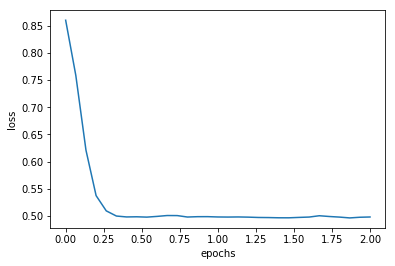

In [72]:
train_pytorch_ch7(optim.SGD,{'lr':0.004,'momentum':0.9},features,labels)

In [76]:
a=torch.tensor([[10],[20],[30]])
b=torch.tensor([1,2,3])
a-b

tensor([[ 9,  8,  7],
        [19, 18, 17],
        [29, 28, 27]])

In [77]:
a.view(-1)-b

tensor([ 9, 18, 27])

In [78]:
a.shape

torch.Size([3, 1])